In [21]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, TimeSeriesSplit, GridSearchCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, classification_report, roc_auc_score, roc_curve
)
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
import matplotlib.pyplot as plt
import seaborn as sns


In [22]:
DROP_COLS = [
    # Identifiers (not predictive)
    'game_id', 'season', 'home_team', 'away_team', 
    'home_team_abbrev', 'away_team_abbrev', 'matchup',
    
    # Target variable
    # 'home_win',
    # 'date'
    
    # Game outcome stats (only known AFTER the game - data leakage)
    'home_gf', 'away_gf', 'home_ga', 'away_ga', 'home_sog', 'away_sog',
    'home_faceoffwin_pct', 'away_faceoffwin_pct',
    'home_powerplays', 'away_powerplays', 'home_powerplay_pct', 'away_powerplay_pct',
    'home_pk', 'away_pk', 'home_pk_pct', 'away_pk_pct',
    'home_pims', 'away_pims', 'home_hits', 'away_hits',
    'home_blockedshots', 'away_blockedshots', 'home_takeaways', 'away_takeaways',
    'home_giveaways', 'away_giveaways',
    
    # Goalie stats from THIS game
    'home_save_pct', 'away_save_pct',
    'home_goalie_save_pct', 'away_goalie_save_pct',
    'home_goalie_ga', 'away_goalie_ga',
    'home_goalie_saves', 'away_goalie_saves',
    'home_goalie_evenStrengthShotsAgainst', 'away_goalie_evenStrengthShotsAgainst',
    'home_goalie_powerPlayShotsAgainst', 'away_goalie_powerPlayShotsAgainst',
    'home_goalie_shorthandedShotsAgainst', 'away_goalie_shorthandedShotsAgainst',
    'home_goalie_evenStrengthGoalsAgainst', 'away_goalie_evenStrengthGoalsAgainst',
    'home_goalie_powerPlayGoalsAgainst', 'away_goalie_powerPlayGoalsAgainst',
]


In [23]:
# list all of the columns
temp_df = pd.read_csv("../scripts/generated/data/nhl_data.csv")

print("All columns in the dataset: ", temp_df.columns.tolist())

All columns in the dataset:  ['game_id', 'date', 'season', 'home_team', 'away_team', 'home_team_abbrev', 'away_team_abbrev', 'home_win', 'home_gf', 'away_gf', 'home_ga', 'away_ga', 'home_sog', 'away_sog', 'home_faceoffwin_pct', 'away_faceoffwin_pct', 'home_powerplays', 'away_powerplays', 'home_powerplay_pct', 'away_powerplay_pct', 'home_pk', 'away_pk', 'home_pk_pct', 'away_pk_pct', 'home_pims', 'away_pims', 'home_hits', 'away_hits', 'home_blockedshots', 'away_blockedshots', 'home_takeaways', 'away_takeaways', 'home_giveaways', 'away_giveaways', 'home_gf_ewm', 'home_ga_ewm', 'home_sog_ewm', 'home_wins_l5', 'home_powerplay_pct_ewm', 'home_penalty_kill_pct_ewm', 'home_powerplays_l5', 'home_penalty_kills_l5', 'home_faceoffwin_pct_ewm', 'home_pims_ewm', 'home_hits_ewm', 'home_blockedshots_ewm', 'home_giveaways_ewm', 'home_takeaways_ewm', 'home_games_l5', 'home_win_pct_l5', 'away_gf_ewm', 'away_ga_ewm', 'away_sog_ewm', 'away_wins_l5', 'away_powerplay_pct_ewm', 'away_penalty_kill_pct_ewm', 'a

In [24]:
HOME_TEAM_L5_COLS = [
    'home_gf_ewm', 'home_ga_ewm', 'home_sog_ewm',
    'home_wins_l5', 'home_win_pct_l5', 'home_powerplay_pct_ewm',
    'home_penalty_kill_pct_ewm', 'home_powerplays_l5', 'home_penalty_kills_l5',
    'home_faceoffwin_pct_ewm', 'home_pims_ewm', 'home_hits_ewm',
    'home_blockedshots_ewm', 'home_giveaways_ewm', 'home_takeaways_ewm',
]

AWAY_TEAM_L5_COLS = [
    'away_gf_ewm', 'away_ga_ewm', 'away_sog_ewm',
    'away_wins_l5', 'away_win_pct_l5', 'away_powerplay_pct_ewm',
    'away_penalty_kill_pct_ewm', 'away_powerplays_l5', 'away_penalty_kills_l5',
    'away_faceoffwin_pct_ewm', 'away_pims_ewm', 'away_hits_ewm',
    'away_blockedshots_ewm', 'away_giveaways_ewm', 'away_takeaways_ewm',
]

GOALIE_L5_COLS = [
    'home_goalie_save_pct_ewm', 'home_goalie_ga_ewm', 'home_goalie_saves_ewm',
    'home_goalie_ev_sa_ewm', 'home_goalie_pp_sa_ewm', 'home_goalie_sh_sa_ewm',
    'home_goalie_ev_ga_ewm', 'home_goalie_pp_ga_ewm', 
    'away_goalie_save_pct_ewm', 'away_goalie_ga_ewm', 'away_goalie_saves_ewm',
    'away_goalie_ev_sa_ewm', 'away_goalie_pp_sa_ewm', 'away_goalie_sh_sa_ewm',
    'away_goalie_ev_ga_ewm', 'away_goalie_pp_ga_ewm',
]

TEAM_GOALIE_PERFORMANCE = [
    'home_team_save_pct_ewm', 'away_team_save_pct_ewm',
]

SEASON_COLS = [
    'home_win_pct_season', 'away_win_pct_season',
    'home_home_win_pct', 'away_away_win_pct',
    'home_gf_per_game_season', 'away_gf_per_game_season',
    'home_pointPctg_season', 'away_pointPctg_season', 'pointPctg_diff',
]

DIFF_COLS = [
    'home_goal_diff_ewm', 'home_ga_diff_ewm', 'home_shot_diff_ewm',
]

STREAKS_AND_REST = [
    'home_win_streak', 'away_win_streak',
    'home_rest_days', 'away_rest_days',
    'home_goalie_rest_days', 'away_goalie_rest_days',
]

HEAD_TO_HEAD = [
    'home_h2h_wins', 'home_h2h_gf', 'away_h2h_wins', 
    'away_h2h_gf', 'home_h2h_wins_diff',
]

FEATURE_COLS = (
    HOME_TEAM_L5_COLS +
    AWAY_TEAM_L5_COLS +
    GOALIE_L5_COLS +
    TEAM_GOALIE_PERFORMANCE +
    SEASON_COLS +
    DIFF_COLS +
    STREAKS_AND_REST +
    HEAD_TO_HEAD
)


In [25]:
# =============================================================================
# 3. LOAD AND EXPLORE DATA
# =============================================================================

# Load data - UPDATE THIS PATH
filepath = "../scripts/generated/data/nhl_data.csv"
df = pd.read_csv(filepath)

print(f"\nDataset shape: {df.shape}")
print(f"Columns in dataset: {len(df.columns)}")
print(f"Date range: {df['date'].min()} to {df['date'].max()}")

# Check target distribution
print("\n" + "="*60)
print("TARGET VARIABLE DISTRIBUTION")
print("="*60)
print(df['home_win'].value_counts())
print(f"\nHome win percentage: {df['home_win'].mean():.2%}")


Dataset shape: (3532, 128)
Columns in dataset: 128
Date range: 2023-10-10 to 2026-02-05

TARGET VARIABLE DISTRIBUTION
home_win
1    1923
0    1609
Name: count, dtype: int64

Home win percentage: 54.45%


In [26]:
# =============================================================================
# 4. PREPARE FEATURES
# =============================================================================

# Check which features are available
available_features = [col for col in FEATURE_COLS if col in df.columns]
missing_features = [col for col in FEATURE_COLS if col not in df.columns]

print("\n" + "="*60)
print("FEATURE AVAILABILITY")
print("="*60)
print(f"Available features: {len(available_features)}/{len(FEATURE_COLS)}")

if missing_features:
    print(f"\nMissing features ({len(missing_features)}):")
    for feat in missing_features[:10]:
        print(f"  - {feat}")
    if len(missing_features) > 10:
        print(f"  ... and {len(missing_features) - 10} more")

# Prepare features and target
X = df[available_features].copy()
y = df['home_win'].copy()

# Keep date for splitting
dates = pd.to_datetime(df['date'])

print(f"\nFeatures shape: {X.shape}")
print(f"Target shape: {y.shape}")

# Check missing values
missing_counts = X.isnull().sum()
if missing_counts.sum() > 0:
    print(f"\nMissing values per feature:")
    print(missing_counts[missing_counts > 0])

# Handle missing values
print(f"\nMissing values before imputation: {X.isnull().sum().sum()}")

# X = X.dropna()

# # Fill with median
# X = X.fillna(X.median())

# # Handle any infinite values
# X = X.replace([np.inf, -np.inf], np.nan)
# X = X.fillna(X.median())

print(f"Missing values after imputation: {X.isnull().sum().sum()}")


FEATURE AVAILABILITY
Available features: 71/71

Features shape: (3532, 71)
Target shape: (3532,)

Missing values per feature:
home_goalie_save_pct_ewm     8
home_goalie_ga_ewm           8
home_goalie_saves_ewm        8
home_goalie_ev_sa_ewm        8
home_goalie_pp_sa_ewm        8
home_goalie_sh_sa_ewm        8
home_goalie_ev_ga_ewm        8
home_goalie_pp_ga_ewm        8
away_goalie_save_pct_ewm    25
away_goalie_ga_ewm          25
away_goalie_saves_ewm       25
away_goalie_ev_sa_ewm       25
away_goalie_pp_sa_ewm       25
away_goalie_sh_sa_ewm       25
away_goalie_ev_ga_ewm       25
away_goalie_pp_ga_ewm       25
home_goalie_rest_days       41
away_goalie_rest_days       61
dtype: int64

Missing values before imputation: 366
Missing values after imputation: 366


In [27]:
# shape
print(f"\nFinal features shape: {X.shape}")
print(f"Final target shape: {y.shape}")


Final features shape: (3532, 71)
Final target shape: (3532,)


In [28]:
# =============================================================================
# 5. TIME-BASED TRAIN/VALIDATION/TEST SPLIT
# =============================================================================

print("\n" + "="*60)
print("TIME-BASED DATA SPLIT")
print("="*60)

non_missing_idx = X.dropna().index

# Sort by date
sort_idx = dates.argsort()
X_sorted = X.loc[non_missing_idx].reset_index(drop=True)
y_sorted = y.loc[non_missing_idx].reset_index(drop=True)
dates_sorted = dates.loc[non_missing_idx].reset_index(drop=True)

# Calculate split indices (60% train, 20% val, 20% test)
n = len(X_sorted)
train_end = int(n * 0.6)
val_end = int(n * 0.8)

# Split data
X_train = X_sorted[:train_end]
y_train = y_sorted[:train_end]
dates_train = dates_sorted[:train_end]

X_val = X_sorted[train_end:val_end]
y_val = y_sorted[train_end:val_end]
dates_val = dates_sorted[train_end:val_end]

X_test = X_sorted[val_end:]
y_test = y_sorted[val_end:]
dates_test = dates_sorted[val_end:]

print(f"\nTrain: {len(X_train)} games ({dates_train.min().date()} to {dates_train.max().date()})")
print(f"  Home win rate: {y_train.mean():.2%}")
print(f"\nValidation: {len(X_val)} games ({dates_val.min().date()} to {dates_val.max().date()})")
print(f"  Home win rate: {y_val.mean():.2%}")
print(f"\nTest: {len(X_test)} games ({dates_test.min().date()} to {dates_test.max().date()})")
print(f"  Home win rate: {y_test.mean():.2%}")


TIME-BASED DATA SPLIT

Train: 2059 games (2023-10-10 to 2025-01-29)
  Home win rate: 54.54%

Validation: 686 games (2025-01-29 to 2025-11-04)
  Home win rate: 57.00%

Test: 687 games (2025-11-04 to 2026-02-05)
  Home win rate: 51.67%


In [29]:
# =============================================================================
# 6. BASELINE MODEL
# =============================================================================

print("\n" + "="*60)
print("BASELINE MODEL (Default Parameters)")
print("="*60)

# Train baseline model
base_rf_model = RandomForestClassifier(n_estimators=100, random_state=42, n_jobs=-1)
base_rf_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = base_rf_model.predict(X_val)
baseline_acc = accuracy_score(y_val, y_val_pred)

print(f"\nBaseline Validation Accuracy: {baseline_acc:.4f}")


BASELINE MODEL (Default Parameters)

Baseline Validation Accuracy: 0.7026


In [30]:
# =============================================================================
# 7. HYPERPARAMETER TUNING
# =============================================================================

print("\n" + "="*60)
print("HYPERPARAMETER TUNING")
print("="*60)

# Define parameter grid
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [10, 20, 30, None],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['sqrt', 'log2']
}

n_combinations = (len(param_grid['n_estimators']) * 
                  len(param_grid['max_depth']) * 
                  len(param_grid['min_samples_split']) * 
                  len(param_grid['min_samples_leaf']) * 
                  len(param_grid['max_features']))

print(f"\nTesting {n_combinations} combinations with 5-fold CV...")
print("This may take several minutes...\n")

# Create GridSearchCV using train+val for CV
X_train_val = pd.concat([X_train, X_val])
y_train_val = pd.concat([y_train, y_val])

rf = RandomForestClassifier(random_state=42, n_jobs=-1)
grid_search = GridSearchCV(
    estimator=rf,
    param_grid=param_grid,
    cv=5,
    scoring='accuracy',
    n_jobs=-1,
    verbose=2
)

# Fit grid search
grid_search.fit(X_train_val, y_train_val)

print("\n" + "="*60)
print("BEST HYPERPARAMETERS")
print("="*60)
for param, value in grid_search.best_params_.items():
    print(f"{param}: {value}")
print(f"\nBest CV Score: {grid_search.best_score_:.4f}")

# Get best model
best_model = grid_search.best_estimator_


HYPERPARAMETER TUNING

Testing 216 combinations with 5-fold CV...
This may take several minutes...

Fitting 5 folds for each of 216 candidates, totalling 1080 fits

BEST HYPERPARAMETERS
max_depth: 30
max_features: sqrt
min_samples_leaf: 4
min_samples_split: 10
n_estimators: 300

Best CV Score: 0.7009


In [31]:
# =============================================================================
# 8. MODEL EVALUATION ON TEST SET
# =============================================================================

print("\n" + "="*60)
print("TEST SET PERFORMANCE")
print("="*60)

# Predictions
# y_test_pred = best_model.predict(X_test)
# y_test_proba = best_model.predict_proba(X_test)[:, 1]
# Predictions
y_test_proba = best_model.predict_proba(X_test)[:, 1]

threshold = 0.53
y_test_pred = (y_test_proba >= threshold).astype(int)


# Calculate metrics
accuracy = accuracy_score(y_test, y_test_pred)
precision = precision_score(y_test, y_test_pred)
recall = recall_score(y_test, y_test_pred)
f1 = f1_score(y_test, y_test_pred)
roc_auc = roc_auc_score(y_test, y_test_proba)

print(f"\nAccuracy:  {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")
print(f"ROC AUC:   {roc_auc:.4f}")

print("\n" + "-"*60)
print("CLASSIFICATION REPORT")
print("-"*60)
print(classification_report(y_test, y_test_pred, target_names=['Away Win', 'Home Win']))

# Confusion matrix
cm = confusion_matrix(y_test, y_test_pred)
print("-"*60)
print("CONFUSION MATRIX")
print("-"*60)
print(cm)
print(f"\nTrue Negatives (Away Wins):  {cm[0,0]}")
print(f"False Positives (Pred Home): {cm[0,1]}")
print(f"False Negatives (Pred Away): {cm[1,0]}")
print(f"True Positives (Home Wins):  {cm[1,1]}")


TEST SET PERFORMANCE

Accuracy:  0.6419
Precision: 0.6408
Recall:    0.6986
F1 Score:  0.6685
ROC AUC:   0.6973

------------------------------------------------------------
CLASSIFICATION REPORT
------------------------------------------------------------
              precision    recall  f1-score   support

    Away Win       0.64      0.58      0.61       332
    Home Win       0.64      0.70      0.67       355

    accuracy                           0.64       687
   macro avg       0.64      0.64      0.64       687
weighted avg       0.64      0.64      0.64       687

------------------------------------------------------------
CONFUSION MATRIX
------------------------------------------------------------
[[193 139]
 [107 248]]

True Negatives (Away Wins):  193
False Positives (Pred Home): 139
False Negatives (Pred Away): 107
True Positives (Home Wins):  248



FEATURE IMPORTANCE ANALYSIS


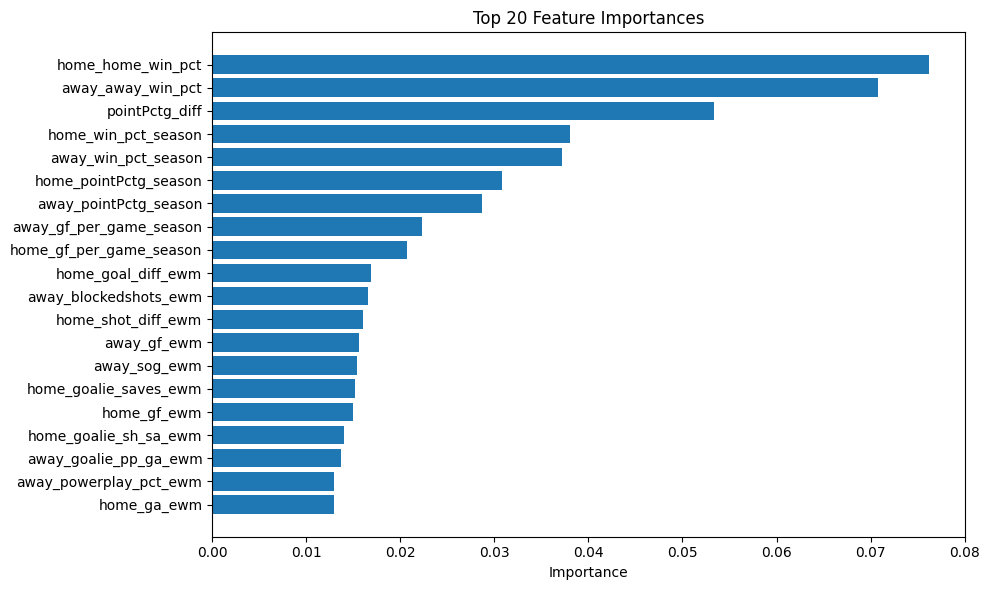

In [32]:
# =============================================================================
# FEATURE IMPORTANCE ANALYSIS
# =============================================================================

print("\n" + "="*60)
print("FEATURE IMPORTANCE ANALYSIS")
print("="*60)

# Build dataframe
fi = pd.DataFrame({
    "feature": available_features,
    "importance": best_model.feature_importances_
}).sort_values("importance", ascending=False).head(20)

# Plot
plt.figure(figsize=(10, 6))
plt.barh(fi["feature"][::-1], fi["importance"][::-1])
plt.title("Top 20 Feature Importances")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()



CREATING VISUALIZATIONS


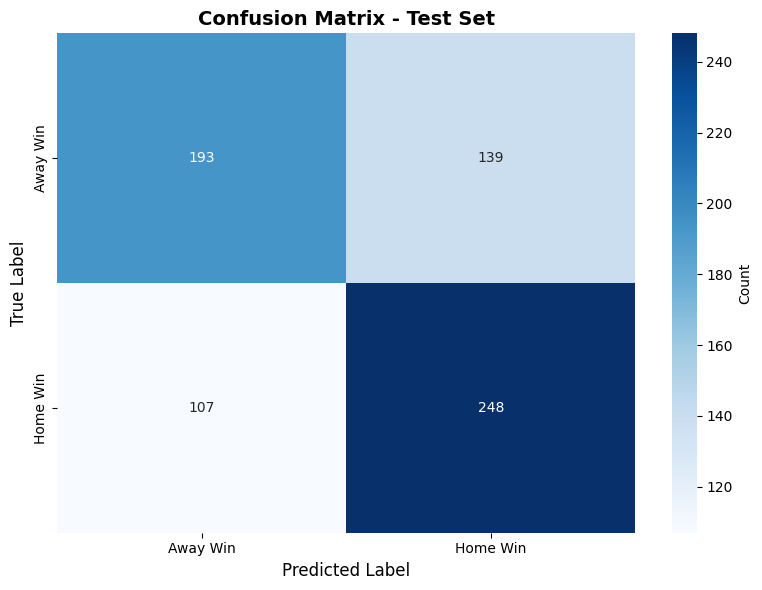

In [33]:
# =============================================================================
# 9. VISUALIZATIONS
# =============================================================================

print("\n" + "="*60)
print("CREATING VISUALIZATIONS")
print("="*60)

# 9.1 Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Away Win', 'Home Win'],
            yticklabels=['Away Win', 'Home Win'],
            cbar_kws={'label': 'Count'})
plt.title('Confusion Matrix - Test Set', fontsize=14, fontweight='bold')
plt.ylabel('True Label', fontsize=12)
plt.xlabel('Predicted Label', fontsize=12)
plt.tight_layout()
# print the figure
plt.show()
plt.close()

In [34]:
# =============================================================================
# 10. FINAL SUMMARY
# =============================================================================

print("\n" + "="*60)
print("FINAL MODEL SUMMARY")
print("="*60)
print(f"\nModel: Random Forest Classifier")
print(f"Features: {len(available_features)}")
print(f"\nData Split (Time-based):")
print(f"  Train:      {len(X_train)} games")
print(f"  Validation: {len(X_val)} games")
print(f"  Test:       {len(X_test)} games")
print(f"\nBest Hyperparameters:")
for param, value in grid_search.best_params_.items():
    print(f"  {param}: {value}")
print(f"\nTest Set Performance:")
print(f"  Accuracy:  {accuracy:.4f}")
print(f"  Precision: {precision:.4f}")
print(f"  Recall:    {recall:.4f}")
print(f"  F1 Score:  {f1:.4f}")
print(f"  ROC AUC:   {roc_auc:.4f}")
print("\n" + "="*60)
print("COMPLETE!")
print("="*60)


FINAL MODEL SUMMARY

Model: Random Forest Classifier
Features: 71

Data Split (Time-based):
  Train:      2059 games
  Validation: 686 games
  Test:       687 games

Best Hyperparameters:
  max_depth: 30
  max_features: sqrt
  min_samples_leaf: 4
  min_samples_split: 10
  n_estimators: 300

Test Set Performance:
  Accuracy:  0.6419
  Precision: 0.6408
  Recall:    0.6986
  F1 Score:  0.6685
  ROC AUC:   0.6973

COMPLETE!


In [35]:
# =============================================================================
# 11. SAVE MODEL
# =============================================================================

import pickle

with open('./models/nhl_rf_model.pkl', 'wb') as f:
    pickle.dump(best_model, f)

with open('./models/feature_names.pkl', 'wb') as f:
    pickle.dump(available_features, f)

print("\nModel saved: nhl_rf_model.pkl")
print("Features saved: feature_names.pkl")


Model saved: nhl_rf_model.pkl
Features saved: feature_names.pkl
